In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import argparse
import pandas as pd
from IPython.display import display

from d_model_evaluate_vis import load_metrics_from_file, print_metrics_summary
PROJECT_DIR = '/Users/xin99/Documents/BloodScan'

def generate_evaluation_chart_from_file(metrics_file, data_type='augmented', output_path=None):
    """
    从保存的metrics文件生成评估图表
    
    Args:
        metrics_file: metrics JSON文件路径
        data_type: 'original' 或 'augmented'，选择使用哪种测试结果数据作图
        output_path: 图表保存路径
    """
    # 加载数据
    metrics = load_metrics_from_file(metrics_file)
    fusion_name = Path(metrics_file).stem.replace('metrics_', '')
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # 根据data_type参数选择数据源
    if data_type not in ['original', 'augmented']:
        raise ValueError("data_type must be 'original' or 'augmented'")
    
    # 提取指定类型的数据
    group_metrics = metrics[data_type]
    detection_rate = group_metrics['detection_rate']
    iou_mean = group_metrics['iou_mean']
    iou_std = group_metrics['iou_std']
    upper_diff = group_metrics['upper_diff_mean']
    upper_diff_std = group_metrics['upper_diff_std']
    lower_diff = group_metrics['lower_diff_mean']
    lower_diff_std = group_metrics['lower_diff_std']
    
    data = [detection_rate, iou_mean, upper_diff, lower_diff]
    stds = [0, iou_std, upper_diff_std, lower_diff_std]  # 检测率无标准差
    
    # 设置x轴位置和宽度
    metrics_labels = ['Detection Rate', 'IoU', 'Upper Surface', 'Lower Surface']
    x_pos = np.arange(len(metrics_labels))
    width = 0.6
    
    # 定义颜色 - 4种不同的基础颜色
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 蓝、橙、绿、红
    
    # 设置左侧y轴 (比例类指标)
    ax1.set_ylabel('Ratio', fontsize=12)
    ax1.set_ylim([0, 1.01])
    ax1.tick_params(axis='y', labelcolor='black')
    
    # 创建右侧y轴 (像素差异指标)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Pixel Difference', fontsize=12)
    ax2.set_ylim([0, 12.01])
    ax2.tick_params(axis='y', labelcolor='black')
    
    # 绘制柱状图
    for i, (metric_name, color) in enumerate(zip(metrics_labels, colors)):
        x_position = x_pos[i]
        
        if i < 2:  # Detection Rate 和 IoU 使用左侧y轴
            ax1.bar(x_position, data[i], width, 
                   yerr=stds[i] if stds[i] > 0 else None,
                   color=color, alpha=0.8, capsize=3)
        else:  # Upper Surface 和 Lower Surface 使用右侧y轴
            ax2.bar(x_position, data[i], width, 
                   yerr=stds[i] if stds[i] > 0 else None,
                   color=color, alpha=0.8, capsize=3)
    
    # 设置x轴
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(metrics_labels, fontsize=11)
    ax1.set_xlabel('Metrics', fontsize=12)
    
    # 添加网格
    ax1.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    
    # 设置标题，显示使用的数据类型
    data_type_label = 'Original Dataset' if data_type == 'original' else 'Augmented Dataset'
    plt.title(f'Dual-Modal YOLO Evaluation Results - {fusion_name} ({data_type_label})', fontsize=14, pad=20)
    
    # 调整布局并保存
    plt.tight_layout()
    plt.show()
    return output_path


def generate_comparison_table(fusion_names, data_type='augmented', metrics_data_dir=None):
    """
    生成模型对比表格
    
    Args:
        fusion_names: 融合策略名称列表
        data_type: 'original' 或 'augmented'，选择使用哪种测试结果数据
        metrics_data_dir: metrics数据目录路径
    
    Returns:
        tuple: (df_display, df_raw) 显示用DataFrame和原始数据DataFrame
    """
    if metrics_data_dir is None:
        metrics_data_dir = 'dual_yolo/evaluation_results_aug/metrics_data'
    metrics_data_dir = os.path.join(PROJECT_DIR, metrics_data_dir)
    
    if data_type not in ['original', 'augmented']:
        raise ValueError("data_type must be 'original' or 'augmented'")
        
    results = []
    
    for fusion_name in fusion_names:
        if "metrics_data" in metrics_data_dir:
            metrics_file = os.path.join(metrics_data_dir, f'metrics_{fusion_name}.json')
        else:
            metrics_file = os.path.join(metrics_data_dir, f'{fusion_name}/metrics_{fusion_name}.json')

        if not os.path.exists(metrics_file):
            print(f"Warning: {metrics_file} not found, skipping {fusion_name}")
            continue
            
        metrics = load_metrics_from_file(metrics_file)
        
        # 根据data_type参数选择数据源
        group_metrics = metrics[data_type]
        
        results.append({
            'Model': fusion_name,
            'Detection Rate (%)': group_metrics['detection_rate'] * 100,
            'IoU': group_metrics['iou_mean'],
            'IoU Std': group_metrics['iou_std'],
            'Upper Error (px)': group_metrics['upper_diff_mean'],
            'Upper Error Std': group_metrics['upper_diff_std'],
            'Lower Error (px)': group_metrics['lower_diff_mean'],
            'Lower Error Std': group_metrics['lower_diff_std'],
            'Samples': group_metrics['total_count'],
            'Detected': group_metrics['detected_count']
        })
    
    df_raw = pd.DataFrame(results)
    
    # 格式化显示列 - 不同列采用不同的小数位数
    df_display = df_raw.copy()
    df_display['Detection Rate (%)'] = df_display['Detection Rate (%)'].apply(lambda x: f"{x:.2f}")
    df_display['IoU'] = df_display.apply(lambda row: f"{row['IoU']:.2f} ± {row['IoU Std']:.2f}", axis=1)
    # Error列使用一位小数
    df_display['Upper Error (px)'] = df_display.apply(lambda row: f"{row['Upper Error (px)']:.1f} ± {row['Upper Error Std']:.1f}", axis=1)
    df_display['Lower Error (px)'] = df_display.apply(lambda row: f"{row['Lower Error (px)']:.1f} ± {row['Lower Error Std']:.1f}", axis=1)
    
    # 选择要显示的列，包含新增的 Detected Samples
    df_display = df_display[['Model', 'Detection Rate (%)', 'IoU', 'Upper Error (px)', 'Lower Error (px)', 'Samples', 'Detected']]
    
    return df_display, df_raw


def style_table(df_display, df_raw):
    """为表格应用样式并高亮最佳值 - 使用更可靠的方法"""
    
    # 1. 计算所有需要高亮的位置
    highlight_positions = {
        'Detection Rate (%)': set(),
        'IoU': set(),
        'Upper Error (px)': set(),
        'Lower Error (px)': set(),
        'Detected': set(),
        'Model': set()
    }
    
    # 统计每行的高亮次数
    highlight_counts = [0] * len(df_raw)
    
    # 计算数值列的高亮位置
    for col_name in ['Detection Rate (%)', 'IoU', 'Detected']:
        if col_name == 'Detection Rate (%)':
            values = df_raw['Detection Rate (%)'].values
        elif col_name == 'IoU':
            values = df_raw['IoU'].values
        else:  # Detected Samples
            values = df_raw['Detected'].values
        
        max_value = values.max()
        best_indices = np.where(values == max_value)[0]
        highlight_positions[col_name] = set(best_indices)
        # 更新高亮计数
        for idx in best_indices:
            highlight_counts[idx] += 1
    
    # 计算Error列的高亮位置 (越小越好)
    for col_name in ['Upper Error (px)', 'Lower Error (px)']:
        if col_name == 'Upper Error (px)':
            values = df_raw['Upper Error (px)'].values
        else:
            values = df_raw['Lower Error (px)'].values
        
        min_value = values.min()
        best_indices = np.where(values == min_value)[0]
        highlight_positions[col_name] = set(best_indices)
        
        # 更新高亮计数
        for idx in best_indices:
            highlight_counts[idx] += 1
    
    # 计算模型名的高亮位置
    max_highlight_count = max(highlight_counts) if highlight_counts else 0
    best_model_indices = [i for i, count in enumerate(highlight_counts) if count == max_highlight_count and count > 0]
    highlight_positions['Model'] = set(best_model_indices)
    
    # 2. 使用lambda函数为每列单独应用样式
    def make_highlighter(col_name):
        def highlight_col(s):
            styles = []
            for i in range(len(s)):
                if i in highlight_positions[col_name]:
                    if col_name == 'Model':
                        styles.append('font-weight: bold; background-color: #fefae6')  # 黄色
                    else:
                        styles.append('font-weight: bold; background-color: #e6f3ff')  # 蓝色
                else:
                    styles.append('')
            return styles
        return highlight_col
    
    # 3. 逐列应用样式
    styled_df = df_display.style
    
    for col_name in df_display.columns:
        if col_name == 'Samples':
            continue
        styled_df = styled_df.apply(make_highlighter(col_name), subset=[col_name])
    
    # 4. 应用表格样式
    styled_df = styled_df.set_table_styles([
        {'selector': 'th', 
         'props': [('background-color', '#f0f0f0'),
                  ('font-weight', 'bold'),
                  ('text-align', 'center'),
                  ('border', '1px solid #ddd')]},
        {'selector': 'td', 
         'props': [('text-align', 'center'),
                  ('border', '1px solid #ddd'),
                  ('padding', '8px')]},
        {'selector': 'table', 
         'props': [('border-collapse', 'collapse'),
                  ('width', '100%')]}
    ])
    
    return styled_df

In [25]:
FUSION_NAME_LIST = ['id', 'crossattn', 'crossattn-30epoch', 'weighted-fusion', 'concat-compress']

# 选择数据类型：'original' 或 'augmented'
DATA_TYPE = 'augmented'  # 可以修改为 'original' 来查看原始测试集结果

# 生成对比表格
df_display, df_raw = generate_comparison_table(FUSION_NAME_LIST, data_type=DATA_TYPE, metrics_data_dir='dual_yolo/evaluation_results_aug_0_1_2_20conf/')

# 显示带样式的表格
styled_table = style_table(df_display, df_raw)
display(styled_table)

data_type_label = '增强测试集' if DATA_TYPE == 'augmented' else '原始测试集'
print(f"\n📊 分析了 {len(FUSION_NAME_LIST)} 个融合策略在{data_type_label}上的效果")
print(f"📈 所有指标已格式化为两位小数，最佳值已高亮显示")
print(f"💡 修改 DATA_TYPE = '{DATA_TYPE}' 来切换数据源")

,Model,Detection Rate (%),IoU,Upper Error (px),Lower Error (px),Samples,Detected
0,id,99.72,0.74 ± 0.22,6.1 ± 6.5,6.9 ± 4.9,360,359
1,crossattn,97.78,0.74 ± 0.22,6.5 ± 4.9,6.4 ± 4.8,360,352
2,crossattn-30epoch,98.89,0.74 ± 0.21,6.2 ± 5.3,6.7 ± 5.0,360,356
3,weighted-fusion,25.28,0.76 ± 0.18,42.4 ± 104.8,9.0 ± 28.1,360,91
4,concat-compress,91.39,0.74 ± 0.22,6.2 ± 5.3,6.5 ± 5.0,360,329



📊 分析了 5 个融合策略在增强测试集上的效果
📈 所有指标已格式化为两位小数，最佳值已高亮显示
💡 修改 DATA_TYPE = 'augmented' 来切换数据源


In [26]:
FUSION_NAME_LIST = ['id', 'crossattn', 'crossattn-30epoch', 'weighted-fusion', 'concat-compress']

# 选择数据类型：'original' 或 'augmented'
DATA_TYPE = 'augmented'  # 可以修改为 'original' 来查看原始测试集结果

# 生成对比表格
df_display, df_raw = generate_comparison_table(FUSION_NAME_LIST, data_type=DATA_TYPE, metrics_data_dir='dual_yolo/evaluation_results_aug_0_1_2_50conf/')

# 显示带样式的表格
styled_table = style_table(df_display, df_raw)
display(styled_table)

data_type_label = '增强测试集' if DATA_TYPE == 'augmented' else '原始测试集'
print(f"\n📊 分析了 {len(FUSION_NAME_LIST)} 个融合策略在{data_type_label}上的效果")
print(f"📈 所有指标已格式化为两位小数，最佳值已高亮显示")
print(f"💡 修改 DATA_TYPE = '{DATA_TYPE}' 来切换数据源")

,Model,Detection Rate (%),IoU,Upper Error (px),Lower Error (px),Samples,Detected
0,id,100.00,0.74 ± 0.22,6.2 ± 6.5,6.9 ± 4.9,360,360
1,crossattn,97.22,0.74 ± 0.22,6.5 ± 5.0,6.4 ± 4.8,360,350
2,crossattn-30epoch,99.44,0.73 ± 0.22,6.2 ± 5.4,6.7 ± 5.1,360,358
3,weighted-fusion,18.06,0.76 ± 0.17,40.9 ± 103.7,7.6 ± 6.8,360,65
4,concat-compress,93.61,0.73 ± 0.22,6.2 ± 5.1,6.6 ± 5.1,360,337



📊 分析了 5 个融合策略在增强测试集上的效果
📈 所有指标已格式化为两位小数，最佳值已高亮显示
💡 修改 DATA_TYPE = 'augmented' 来切换数据源


In [27]:
FUSION_NAME_LIST = ['id', 'crossattn', 'crossattn-30epoch', 'weighted-fusion', 'concat-compress']

# 选择数据类型：'original' 或 'augmented'
DATA_TYPE = 'augmented'  # 可以修改为 'original' 来查看原始测试集结果

# 生成对比表格
df_display, df_raw = generate_comparison_table(FUSION_NAME_LIST, data_type=DATA_TYPE, metrics_data_dir='dual_yolo/evaluation_results_aug_0_1_2_70conf/')

# 显示带样式的表格
styled_table = style_table(df_display, df_raw)
display(styled_table)

data_type_label = '增强测试集' if DATA_TYPE == 'augmented' else '原始测试集'
print(f"\n📊 分析了 {len(FUSION_NAME_LIST)} 个融合策略在{data_type_label}上的效果")
print(f"📈 所有指标已格式化为两位小数，最佳值已高亮显示")
print(f"💡 修改 DATA_TYPE = '{DATA_TYPE}' 来切换数据源")

,Model,Detection Rate (%),IoU,Upper Error (px),Lower Error (px),Samples,Detected
0,id,91.67,0.73 ± 0.22,6.2 ± 6.7,7.0 ± 5.0,360,330
1,crossattn,90.56,0.74 ± 0.22,6.5 ± 5.1,6.5 ± 4.9,360,326
2,crossattn-30epoch,94.72,0.73 ± 0.22,6.2 ± 5.4,6.8 ± 5.1,360,341
3,weighted-fusion,9.44,0.77 ± 0.17,41.8 ± 104.3,7.6 ± 6.5,360,34
4,concat-compress,86.11,0.73 ± 0.22,6.2 ± 5.2,6.6 ± 5.2,360,310



📊 分析了 5 个融合策略在增强测试集上的效果
📈 所有指标已格式化为两位小数，最佳值已高亮显示
💡 修改 DATA_TYPE = 'augmented' 来切换数据源


In [33]:
FUSION_NAME_LIST = ['id', 'crossattn', 'crossattn-30epoch', 'weighted-fusion', 'concat-compress']

# 选择数据类型：'original' 或 'augmented'
DATA_TYPE = 'augmented'  # 可以修改为 'original' 来查看原始测试集结果

# 生成对比表格
df_display, df_raw = generate_comparison_table(FUSION_NAME_LIST, data_type=DATA_TYPE, metrics_data_dir='dual_yolo/evaluation_results_aug_0_1_2_72conf/')

# 显示带样式的表格
styled_table = style_table(df_display, df_raw)
display(styled_table)

data_type_label = '增强测试集' if DATA_TYPE == 'augmented' else '原始测试集'
print(f"\n📊 分析了 {len(FUSION_NAME_LIST)} 个融合策略在{data_type_label}上的效果")
print(f"📈 所有指标已格式化为两位小数，最佳值已高亮显示")
print(f"💡 修改 DATA_TYPE = '{DATA_TYPE}' 来切换数据源")

,Model,Detection Rate (%),IoU,Upper Error (px),Lower Error (px),Samples,Detected
0,crossattn,88.89,0.74 ± 0.22,6.5 ± 5.0,6.5 ± 4.9,360,320
1,concat-compress,83.89,0.73 ± 0.22,6.2 ± 5.2,6.6 ± 5.2,360,302



📊 分析了 5 个融合策略在增强测试集上的效果
📈 所有指标已格式化为两位小数，最佳值已高亮显示
💡 修改 DATA_TYPE = 'augmented' 来切换数据源


In [30]:
FUSION_NAME_LIST = ['id', 'crossattn', 'crossattn-30epoch', 'weighted-fusion', 'concat-compress']

# 选择数据类型：'original' 或 'augmented'
DATA_TYPE = 'augmented'  # 可以修改为 'original' 来查看原始测试集结果

# 生成对比表格
df_display, df_raw = generate_comparison_table(FUSION_NAME_LIST, data_type=DATA_TYPE, metrics_data_dir='dual_yolo/evaluation_results_aug_0_1_2_75conf/')

# 显示带样式的表格
styled_table = style_table(df_display, df_raw)
display(styled_table)

data_type_label = '增强测试集' if DATA_TYPE == 'augmented' else '原始测试集'
print(f"\n📊 分析了 {len(FUSION_NAME_LIST)} 个融合策略在{data_type_label}上的效果")
print(f"📈 所有指标已格式化为两位小数，最佳值已高亮显示")
print(f"💡 修改 DATA_TYPE = '{DATA_TYPE}' 来切换数据源")

,Model,Detection Rate (%),IoU,Upper Error (px),Lower Error (px),Samples,Detected
0,id,80.83,0.73 ± 0.23,6.3 ± 6.9,7.1 ± 5.1,360,291
1,crossattn,85.56,0.74 ± 0.22,6.5 ± 5.0,6.5 ± 5.0,360,308
2,crossattn-30epoch,86.39,0.73 ± 0.22,6.3 ± 5.5,6.9 ± 5.2,360,311
3,weighted-fusion,6.39,0.76 ± 0.17,48.8 ± 114.7,7.8 ± 7.0,360,23
4,concat-compress,76.67,0.73 ± 0.22,6.1 ± 5.2,6.6 ± 5.1,360,276



📊 分析了 5 个融合策略在增强测试集上的效果
📈 所有指标已格式化为两位小数，最佳值已高亮显示
💡 修改 DATA_TYPE = 'augmented' 来切换数据源


In [14]:
FUSION_NAME_LIST = ['id_copy', 'crossattn_copy', 'crossattn-30epoch_copy', 'weighted-fusion_copy', 'concat-compress_copy']
FUSION_NAME_LIST = ['id', 'crossattn', 'weighted-fusion', 'concat-compress']

# 选择数据类型：'original' 或 'augmented'
DATA_TYPE = 'augmented'  # 可以修改为 'original' 来查看原始测试集结果

# 生成对比表格
df_display, df_raw = generate_comparison_table(FUSION_NAME_LIST, data_type=DATA_TYPE)

# 显示带样式的表格
styled_table = style_table(df_display, df_raw)
display(styled_table)

data_type_label = '增强测试集' if DATA_TYPE == 'augmented' else '原始测试集'
print(f"\n📊 分析了 {len(FUSION_NAME_LIST)} 个融合策略在{data_type_label}上的效果")
print(f"📈 所有指标已格式化为两位小数，最佳值已高亮显示")
print(f"💡 修改 DATA_TYPE = '{DATA_TYPE}' 来切换数据源")

,Model,Detection Rate (%),IoU,Upper Error (px),Lower Error (px),Samples,Detected
0,id,96.94,0.51 ± 0.20,4.5 ± 3.1,5.7 ± 5.0,360,349
1,crossattn,100.00,0.57 ± 0.19,2.5 ± 1.9,4.9 ± 4.1,360,360
2,weighted-fusion,64.72,0.60 ± 0.19,3.7 ± 5.2,3.4 ± 3.1,360,233
3,concat-compress,99.44,0.56 ± 0.20,2.6 ± 2.0,4.4 ± 3.8,360,358



📊 分析了 4 个融合策略在增强测试集上的效果
📈 所有指标已格式化为两位小数，最佳值已高亮显示
💡 修改 DATA_TYPE = 'augmented' 来切换数据源


In [128]:
FUSION_NAME_LIST = ['id_copy', 'crossattn_copy', 'crossattn-30epoch_copy', 'weighted-fusion_copy', 'concat-compress_copy']
# FUSION_NAME_LIST = ['id', 'crossattn', 'weighted-fusion', 'concat-compress']

# 选择数据类型：'original' 或 'augmented'
DATA_TYPE = 'original'  # 可以修改为 'original' 来查看原始测试集结果

# 生成对比表格
df_display, df_raw = generate_comparison_table(FUSION_NAME_LIST, data_type=DATA_TYPE)

# 显示带样式的表格
styled_table = style_table(df_display, df_raw)
display(styled_table)

data_type_label = '增强测试集' if DATA_TYPE == 'augmented' else '原始测试集'
print(f"\n📊 分析了 {len(FUSION_NAME_LIST)} 个融合策略在{data_type_label}上的效果")
print(f"📈 所有指标已格式化为两位小数，最佳值已高亮显示")
print(f"💡 修改 DATA_TYPE = '{DATA_TYPE}' 来切换数据源")

,Model,Detection Rate (%),IoU,Upper Error (px),Lower Error (px),Samples,Detected
0,id_copy,100.00,0.56 ± 0.20,2.8 ± 1.8,4.8 ± 4.3,40,40
1,crossattn_copy,100.00,0.55 ± 0.20,2.4 ± 1.8,5.4 ± 4.3,40,40
2,crossattn-30epoch_copy,100.00,0.56 ± 0.19,2.4 ± 1.7,5.9 ± 3.9,40,40
3,weighted-fusion_copy,72.50,0.57 ± 0.21,3.8 ± 5.2,3.6 ± 3.4,40,29
4,concat-compress_copy,100.00,0.56 ± 0.21,2.6 ± 1.8,4.7 ± 4.0,40,40



📊 分析了 5 个融合策略在原始测试集上的效果
📈 所有指标已格式化为两位小数，最佳值已高亮显示
💡 修改 DATA_TYPE = 'original' 来切换数据源


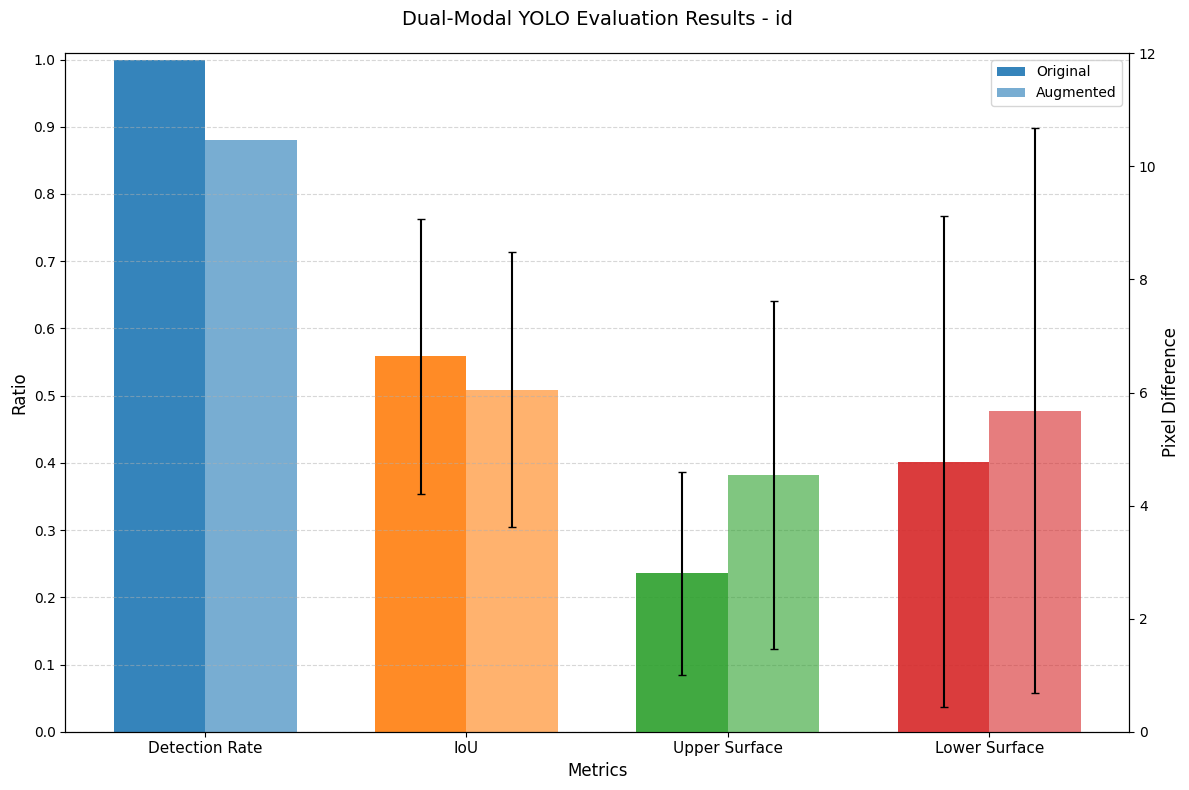

In [66]:
FUSION_NAME = 'id'

metrics_file = os.path.join(PROJECT_DIR, f'dual_yolo/evaluation_results_aug/metrics_data/metrics_{FUSION_NAME}.json')
metrics = load_metrics_from_file(metrics_file)

generate_evaluation_chart_from_file(metrics_file)

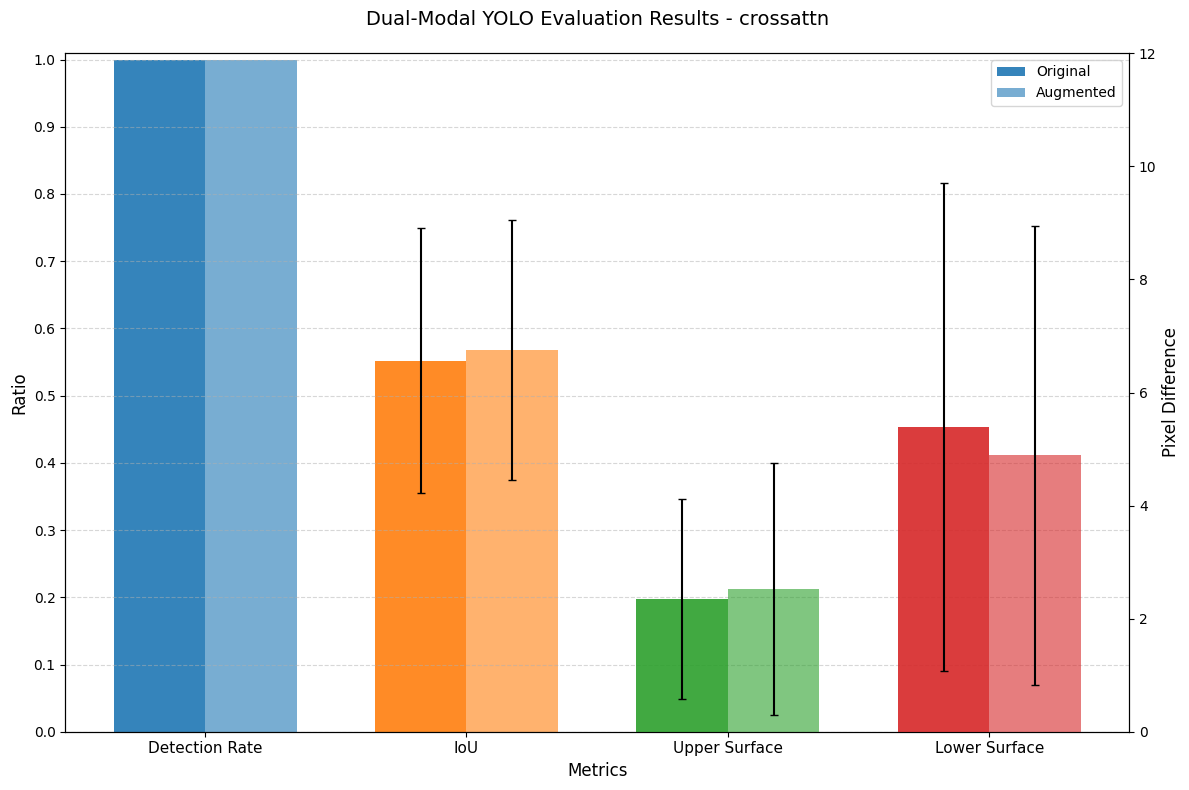

In [67]:
FUSION_NAME = 'crossattn'

metrics_file = os.path.join(PROJECT_DIR, f'dual_yolo/evaluation_results_aug/metrics_data/metrics_{FUSION_NAME}.json')
metrics = load_metrics_from_file(metrics_file)

generate_evaluation_chart_from_file(metrics_file)

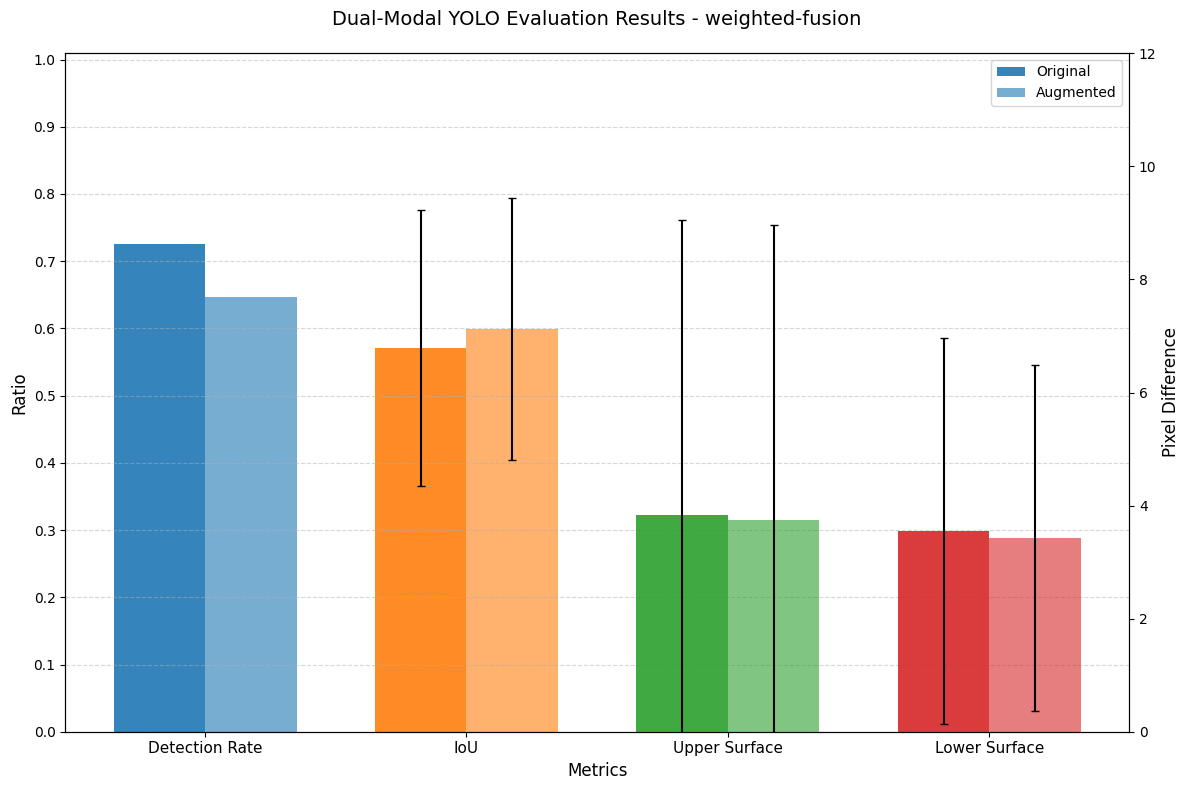

In [68]:
FUSION_NAME = 'weighted-fusion'

metrics_file = os.path.join(PROJECT_DIR, f'dual_yolo/evaluation_results_aug/metrics_data/metrics_{FUSION_NAME}.json')
metrics = load_metrics_from_file(metrics_file)

generate_evaluation_chart_from_file(metrics_file)

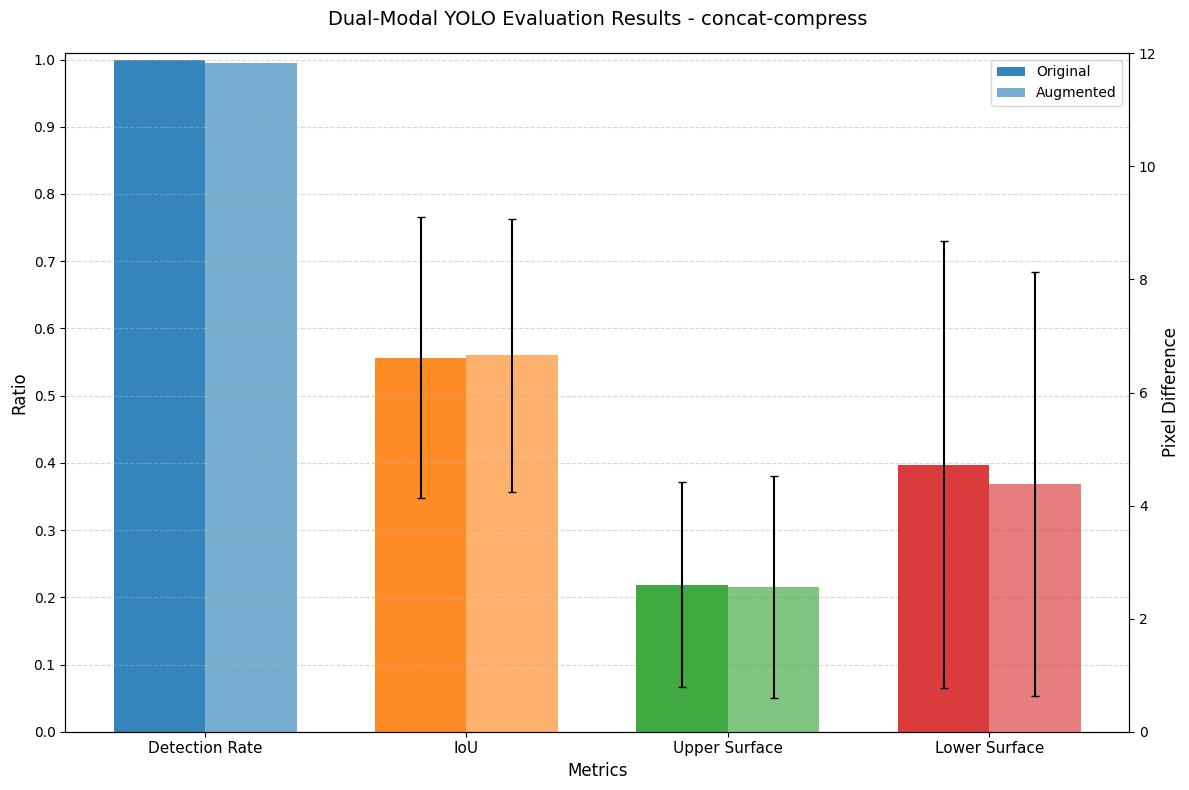

In [69]:
FUSION_NAME = 'concat-compress'

metrics_file = os.path.join(PROJECT_DIR, f'dual_yolo/evaluation_results_aug/metrics_data/metrics_{FUSION_NAME}.json')
metrics = load_metrics_from_file(metrics_file)

generate_evaluation_chart_from_file(metrics_file)